In [1]:
from packages import kuramoto as kr
from packages import kuramoto_nex as nkr
from packages import plotting

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from tqdm import tqdm, trange

<Axes: xlabel='Time', ylabel='$\\sin(\\theta)$'>

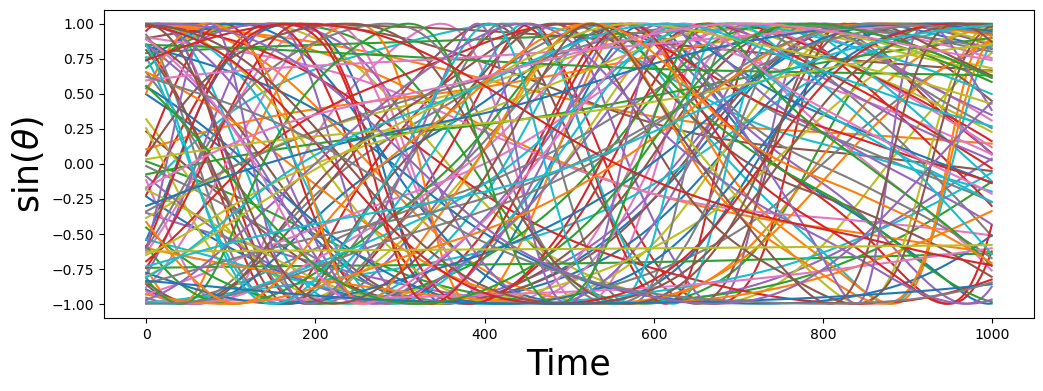

In [2]:
np.random.seed(42)
NODE = 100
graph_nx = nx.erdos_renyi_graph(n=NODE, p=1, seed=42) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)
model = kr.Kuramoto(coupling=2.7, dt=0.01, T=10, n_nodes=len(graph))

act_mat = model.run(adj_mat=graph)
plotting.plot_activity(act_mat)


In [3]:
t = np.linspace(0, 4, 51)
order_ex = []
variance_ex = []

order_nex = []
variance_nex = []

np.random.seed(42)
init_phase = 2 * np.pi * np.random.random(size=NODE)
natfreqs = np.random.normal(loc = 0, scale = 1, size = NODE)

for k in tqdm(t):
    model_ex = kr.Kuramoto(coupling=k, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
    model_nex = nkr.Kuramoto(coupling=k, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
    # Run simulation - output is time series for all nodes (node vs time)
    act_mat_ex = model_ex.run(adj_mat=graph, angles_vec = init_phase)
    act_mat_nex = model_nex.run(adj_mat=graph, angles_vec = init_phase)

    order_ex.append(model_ex.phase_coherence(act_mat_ex[:,-1]))
    variance_ex.append(model_ex.mean_frequency(act_mat_ex, graph))

    order_nex.append(model_nex.phase_coherence(act_mat_nex[:,-1]))
    variance_nex.append(model_nex.mean_frequency(act_mat_nex, graph))


100%|██████████| 51/51 [00:15<00:00,  3.37it/s]


In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot figure with shared axes
fig = make_subplots(rows=1, cols=2, subplot_titles=["(a) Kuramoto Order Parameters", "(b) Variance Order Parameters"], horizontal_spacing=0.1, shared_xaxes=True)

# Add traces to subplot 1
fig.add_trace(
    go.Scatter(x=t, y=order_ex, mode='markers+lines', marker=dict(color='red', size=4), line=dict(width=0.8), name='Order Ex'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=t, y=order_nex, mode='markers+lines', marker=dict(color='black', size=4), line=dict(width=0.8), name='Order Nex'),
    row=1, col=1
)
fig.update_yaxes(title_text='$r$', range=[0,1], row=1, col=1)

# Add traces to subplot 2
fig.add_trace(
    go.Scatter(x=t, y=variance_ex, mode='markers+lines', marker=dict(color='red', size=4), line=dict(width=0.8), name='Variance Ex'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=t, y=variance_nex, mode='markers+lines', marker=dict(color='black', size=4), line=dict(width=0.8), name='Variance Nex'),
    row=1, col=2
)
fig.update_yaxes(title_text=r'$r_{var}$', range=[0,1], row=1, col=2)

# Update layout with synchronized hovermode
fig.update_layout(height=500, width=900, showlegend=False, title_text=f"Kuramoto and Variance Order Parameters (N={NODE})", title_x=0.5, hovermode='x unified')

fig.show()


In [24]:
critical_coupling = 2.7

critical_model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=10.01, n_nodes=len(graph), natfreqs=natfreqs)
act_mat = critical_model.run(adj_mat=graph, angles_vec = init_phase)

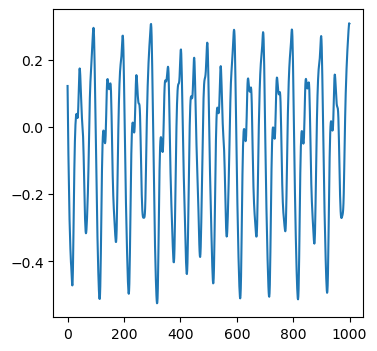

In [25]:
data = np.loadtxt('MackeyGlass.txt')
plt.figure(figsize=(4,4))
plt.plot(data[:1000])

<Axes: xlabel='Time', ylabel='$\\sin(\\theta)$'>

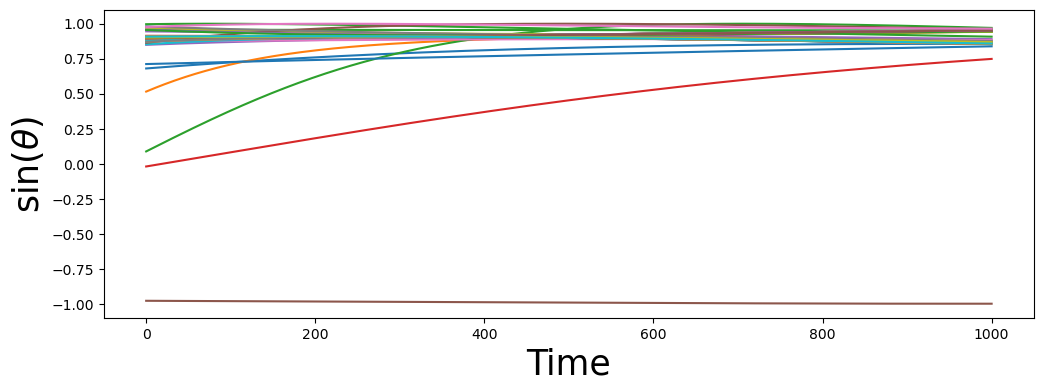

In [26]:
state = act_mat[:,-1]
state[0] += data[0]

act_mat = critical_model.run(adj_mat=graph, angles_vec = state)
plotting.plot_activity(act_mat)

In [27]:
def getReservoir(matrix, time_interval=10):
    sampled_matrix = matrix[:, ::time_interval]
    diff_matrix = np.diff(sampled_matrix, n=1, axis=1)
    reservoir_t = diff_matrix.flatten(order='K')
    #print(sampled_matrix.shape)
    #print(diff_matrix.shape)
    #print(reservoir_t.shape)

    return reservoir_t

In [28]:
def getLastPhase(matrix):
    return matrix[:,-1]

In [29]:
def getPerturbedPhase(t, input_data, index, phase):
    for (i,j) in enumerate(index):
        phase[j] += input_data[t, i]
    
    return phase

In [30]:
def getNextPhase(matrix, model):
    act_mat = model.run(adj_mat=graph, angles_vec=matrix)
    phase = getLastPhase(matrix=act_mat)
    
    return phase

In [31]:
def ridge_regression(trainRes, trainData, reg):
    ResSize = trainRes.shape[1]
    Wout = np.linalg.solve(np.dot(trainRes.T, trainRes) + reg*np.eye(ResSize), np.dot(trainRes.T, trainData))
    return Wout

In [39]:
ResSize = 1500
push = 500
trainLen = ResSize-push
input_data = data.reshape(-1,1)
trainData = input_data[push+1:push+trainLen+1,:]

sample_interval=10

In [40]:
# Now we are ready to perturb data
input_interval = 1
reservoir = []

act_mat_hist = []

synced_phases = act_mat[:,-1]

model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=0.01, n_nodes=NODE, natfreqs=natfreqs)
synced_phases = getNextPhase(matrix=synced_phases, model=model)

model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=input_interval+0.01, n_nodes=NODE, natfreqs=natfreqs)

for t in trange(0, ResSize):
    perturbed_phases = getPerturbedPhase(t=t, input_data=input_data, index=[0], phase=synced_phases)
    act_mat = model.run(adj_mat=graph, angles_vec=perturbed_phases)
    
    reservoir.append(getReservoir(matrix=act_mat, time_interval=sample_interval))
    synced_phases = getLastPhase(matrix=act_mat)

    act_mat_hist.append(act_mat)

100%|██████████| 1500/1500 [00:19<00:00, 75.63it/s]


In [41]:
reservoir_T = np.vstack(reservoir)
trainRes = reservoir_T[push:push+trainLen,:]
print(trainRes.shape, trainData.shape)

(1000, 1000) (1000, 1)


In [42]:
#Wout = np.matmul(np.linalg.pinv(trainRes), trainData)

reg = 1e-8  # regularization coefficient
Wout = ridge_regression(trainRes, trainData, reg)

In [43]:
testLen = 1000
testData = input_data[push+trainLen+1:push+trainLen+1+testLen,:]

target = trainData[-1,:].reshape(-1,1)

pred = []

model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=0.01, n_nodes=NODE, natfreqs=natfreqs)
synced_phases = getNextPhase(matrix=synced_phases, model=model)

model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=input_interval+0.01, n_nodes=NODE, natfreqs=natfreqs)

for t in trange(0, testLen):
    for (i,j) in enumerate([0]):
        synced_phases[j] += target[i]
        
    act_mat = model.run(adj_mat=graph, angles_vec = synced_phases)
    act_mat_sampled = act_mat[:, ::sample_interval]
    act_mat_diff = np.diff(act_mat_sampled, n=1, axis=1)
    reservoir_t = act_mat_diff.flatten(order='K')
    pred.append(np.matmul(reservoir_t, Wout))

    synced_phases = getLastPhase(matrix=act_mat)
    target = pred[-1]

100%|██████████| 1000/1000 [00:13<00:00, 74.77it/s]


In [44]:
pred = np.vstack(pred)

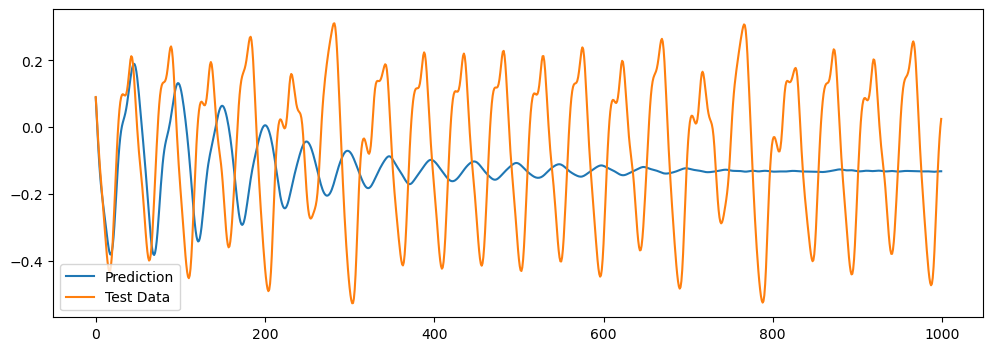

In [45]:
plt.figure(figsize=(12,4))
plt.plot(pred, label='Prediction')
plt.plot(testData, label='Test Data')
plt.legend()